<a href="https://colab.research.google.com/github/yjkno1/AI_TEAM/blob/main/IsolationForest_HTTP_0406.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**필요파일 Import**


In [ ]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import IsolationForest

import ftplib
import os
import pickle
from os import unlink

import plotly.express as px

# Google Drive 에서 파일 가져올때 사용
# from google.colab import drive
# drive.mount('/gdrive', force_remount=True)


**Dataframe 생성**

In [ ]:
# 위와같이 파일을 읽을때 date 컬럼의 타입을 지정할수 있고
# df['srvtime'] = pd.to_datetime(df['srvtime]) 이런형태로 나중에 변경 할수도 있다.

csv_file = "http://yjkno1.synology.me:8081/file/http_csv.csv"

# 가져올 비율 0.1 은 10%
train_per = 0.7
real_per = 0.3

df = pd.read_csv(csv_file, skiprows = lambda x:x>0 and np.random.rand() > train_per)

rDf = pd.read_csv(csv_file, skiprows = lambda x:x>0 and np.random.rand() > real_per)

allDf = pd.read_csv(csv_file)

df.describe()

df.info()

df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397181 entries, 0 to 397180
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   time_stamp  397181 non-null  int64  
 1   value_1     397181 non-null  float64
 2   value_2     397181 non-null  float64
 3   value_3     397181 non-null  float64
 4   abnomal     397181 non-null  int64  
dtypes: float64(3), int64(2)
memory usage: 15.2 MB


,time_stamp,value_1,value_2,value_3,abnomal
0,1,-2.302585,5.371103,10.716107,0
1,5,-2.302585,5.476882,6.186414,0
2,6,-2.302585,5.472691,7.156255,0
3,7,-2.302585,5.460011,7.198258,0
4,8,-2.302585,5.455748,7.218250,0
...,...,...,...,...,...
397176,567490,-2.302585,5.673667,6.999514,0
397177,567491,-2.302585,5.673667,7.529460,0
397178,567492,-2.302585,5.069533,9.668278,0
397179,567495,-2.302585,5.389528,5.464255,0


**index 기준 Metric 만들기**


In [ ]:
x_train = df


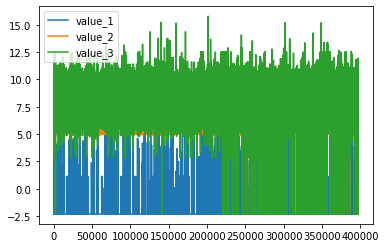

In [ ]:
x_train[["value_1", "value_2", "value_3"]].plot()

**Model 만들기 함수**

In [ ]:
def isolation_forest_model(state_seed=20, n_estimators=100, max_samples=128, contamination=float(0.004)):
  state_value = np.random.RandomState(state_seed)
  return IsolationForest(n_estimators=n_estimators, max_samples=max_samples, contamination=contamination, random_state=state_value)


# ftp 접속 후 ftp객체 반환
def ftp_login(host, port, user, password):
  ftp=ftplib.FTP()
  ftp.connect(host,port)
  ftp.login(user, password)
  ftp.cwd("./")
  return ftp

# model을 ftp로 업로드
def save_model_to_ftp(ftp, filename, model):
  myfile = open(filename,'wb')
  # Save model
  pickle.dump(model, myfile)
  ftpFile = open(filename, 'rb')
  ftp.storbinary("STOR /share/"+filename, ftpFile)
  myfile.close()
  ftpFile.close()

# ftp에서 model을 Load
def load_model_to_ftp(ftp, filename):
  myfile = open(filename,'wb')
  ftp.retrbinary("RETR /share/"+filename, myfile.write)
  myfile.close()
  ftpFile = open(filename, 'rb')
  model = pickle.load(ftpFile)
  ftpFile.close()
  return model

def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,
                          normalize=False):
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


**Model 생성**

In [ ]:
isol = isolation_forest_model(20, 100, 128, float(0.004))

isol

IsolationForest(behaviour='deprecated', bootstrap=False, contamination=0.004,
                max_features=1.0, max_samples=128, n_estimators=100,
                n_jobs=None,
                random_state=RandomState(MT19937) at 0x7F677BE5C9E0, verbose=0,
                warm_start=False)

In [ ]:
isol.fit(x_train[["value_1", "value_2", "value_3"]])


IsolationForest(behaviour='deprecated', bootstrap=False, contamination=0.004,
                max_features=1.0, max_samples=128, n_estimators=100,
                n_jobs=None,
                random_state=RandomState(MT19937) at 0x7F677BE5C9E0, verbose=0,
                warm_start=False)

In [ ]:
#x_test = rDf[rDf.eq(df).any(axis=1) == False].copy()
x_test = rDf
#x_test = allDf
x_test


#x_test[["value_1", "value_2", "value_3"]]

,time_stamp,value_1,value_2,value_3,abnomal
0,3,-2.302585,5.464255,7.113224,0
1,6,-2.302585,5.472691,7.156255,0
2,10,-2.302585,5.199049,8.603389,0
3,11,-2.302585,5.215479,4.821088,0
4,12,-2.302585,5.220896,9.107211,0
...,...,...,...,...,...
170237,567487,-2.302585,5.673667,7.090160,0
170238,567490,-2.302585,5.673667,6.999514,0
170239,567491,-2.302585,5.673667,7.529460,0
170240,567493,-2.302585,5.389528,5.497578,0


In [ ]:
# # Model 저장해 두기.
# filename="iForest_HTTP.model"

# ftp = ftp_login("yjkno1.synology.me", 2121, "ftp_user", "wnsxhtm1212")

# # Model 저장하기
# save_model_to_ftp(ftp, filename)

# # Model 불러오기
# i_sol = load_model_to_ftp(ftp, filename)

# print(i_sol)


IsolationForest(behaviour='deprecated', bootstrap=False, contamination=0.004,
                max_features=1.0, max_samples=128, n_estimators=100,
                n_jobs=None,
                random_state=RandomState(MT19937) at 0x7F49E1110D10, verbose=0,
                warm_start=False)


In [ ]:
series = isol.predict(x_test[["value_1", "value_2", "value_3"]])
print(series)
print(series.size)
#x_test = x_test.reset_index()

x_test['outliers']= pd.Series(series).apply(lambda x: '1' if (x == -1) else '0' )

print(x_test)
print(series.size)

# 이상데이터 건수
print(x_test[x_test['outliers']=='1'].count())

# 정상데이터 건수
print(x_test[x_test['outliers']=='0'].count())

print(x_test.isnull().sum().sum())

print(x_test)

[1 1 1 ... 1 1 1]
170242
        time_stamp   value_1   value_2   value_3  abnomal outliers
0                3 -2.302585  5.464255  7.113224        0        0
1                6 -2.302585  5.472691  7.156255        0        0
2               10 -2.302585  5.199049  8.603389        0        0
3               11 -2.302585  5.215479  4.821088        0        0
4               12 -2.302585  5.220896  9.107211        0        0
...            ...       ...       ...       ...      ...      ...
170237      567487 -2.302585  5.673667  7.090160        0        0
170238      567490 -2.302585  5.673667  6.999514        0        0
170239      567491 -2.302585  5.673667  7.529460        0        0
170240      567493 -2.302585  5.389528  5.497578        0        0
170241      567498 -2.302585  5.389528  7.001337        0        0

[170242 rows x 6 columns]
170242
time_stamp    510
value_1       510
value_2       510
value_3       510
abnomal       510
outliers      510
dtype: int64
time_stamp    16

**평가**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170242 entries, 0 to 170241
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   time_stamp  170242 non-null  int64  
 1   value_1     170242 non-null  float64
 2   value_2     170242 non-null  float64
 3   value_3     170242 non-null  float64
 4   abnomal     170242 non-null  int64  
 5   outliers    170242 non-null  int64  
dtypes: float64(3), int64(3)
memory usage: 7.8 MB


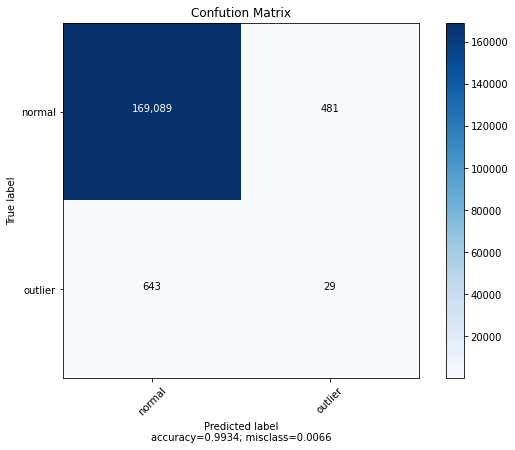

In [ ]:
from sklearn.metrics import confusion_matrix

x_test["outliers"] = pd.to_numeric(x_test["outliers"])

x_test.info()

CM = confusion_matrix(x_test[["abnomal"]], x_test[["outliers"]])

plot_confusion_matrix(CM, target_names=["normal", "outlier"], title="Confution Matrix", normalize = False)



In [ ]:
from sklearn.metrics import classification_report

print(x_test[x_test["abnomal"] == 1])
print(x_test[x_test["outliers"] == 1])

print(classification_report(x_test[["abnomal"]], x_test[["outliers"]], target_names=['class 0', 'class 1']))

        time_stamp   value_1    value_2   value_3  abnomal  outliers
93335       311456 -2.302585  10.906691  9.025708        1         0
93336       311458 -2.302585  10.906691  9.025708        1         0
93337       311469 -2.302585  10.906691  9.025708        1         0
93338       311470 -2.302585  10.906691  9.025708        1         0
93339       311472 -2.302585  10.906691  9.025708        1         0
...            ...       ...        ...       ...      ...       ...
154331      514426 -2.302585  10.906691  9.025708        1         0
154332      514432 -2.302585  10.906691  9.025708        1         0
154333      514433 -2.302585  10.906691  9.025708        1         0
154334      514436 -2.302585  10.906691  9.025708        1         0
154335      514438 -2.302585  10.906691  9.025708        1         0

[672 rows x 6 columns]
        time_stamp   value_1   value_2    value_3  abnomal  outliers
851           2946 -2.302585  5.011302  12.491233        0         1
1761      

In [ ]:
from sklearn.metrics import f1_score, precision_recall_fscore_support

# F1 Score
#print("F1 score", round(f1_score(y_valid,pred, average='binary'), 4))

precision,recall,fbeta_score, support = precision_recall_fscore_support(x_test[["abnomal"]], x_test[["outliers"]], average="binary")

#precision,recall,fbeta_score, support  = precision_recall_fscore_support()
print("precision ", round((precision), 4))
print("recall ", round((recall), 4))
print("F1 score on Test", round((fbeta_score), 4))

precision  0.0569
recall  0.0432
F1 score on Test 0.0491


In [ ]:
print(x_test)

print(x_test[x_test['outliers'] == x_test['abnomal']])


        time_stamp   value_1   value_2   value_3  abnomal  outliers
0                3 -2.302585  5.464255  7.113224        0         0
1                6 -2.302585  5.472691  7.156255        0         0
2               10 -2.302585  5.199049  8.603389        0         0
3               11 -2.302585  5.215479  4.821088        0         0
4               12 -2.302585  5.220896  9.107211        0         0
...            ...       ...       ...       ...      ...       ...
170237      567487 -2.302585  5.673667  7.090160        0         0
170238      567490 -2.302585  5.673667  6.999514        0         0
170239      567491 -2.302585  5.673667  7.529460        0         0
170240      567493 -2.302585  5.389528  5.497578        0         0
170241      567498 -2.302585  5.389528  7.001337        0         0

[170242 rows x 6 columns]
        time_stamp   value_1   value_2   value_3  abnomal  outliers
0                3 -2.302585  5.464255  7.113224        0         0
1                6 -2

**F1 Score 기준 최적 하이퍼 파라미터 찾기**


In [ ]:
def find_hyperparameter_isolation_forest(train, test):
  # isolation_forest_model(state_seed=20, n_estimators=100, max_samples=128, contamination=float(0.004))

  n_estimators = [50, 100]
  max_samples = [128, 256]
  contaminations = [float(0.002), float(0.004), float(0.006)]

  x_test = rDf

  hyperF1 = []

  for i in range(len(contaminations)):
    contamination = contaminations[i]
    
    for ii in range(len(n_estimators)):
      n_estimator = n_estimators[ii]
      
      for jj in range(len(max_samples)):
        max_sample = max_samples[jj]
        
        ifm = isolation_forest_model(n_estimators=n_estimator, max_samples=max_sample, contamination=contamination)
        ifm.fit(train[["value_1", "value_2", "value_3"]])
        series = ifm.predict(test[["value_1", "value_2", "value_3"]])
        test['outliers']= pd.Series(series).apply(lambda x: 1 if (x == -1) else 0 )
      
        f = f1_score(test[["abnomal"]], test[["outliers"]], average='binary')
        #print("F1 score on test", round(f,4), " with epsilon ", eps)
        print('contamination : {0}, n_estimator : {1}, max_sample : {2}, F1 : {3}'.format(contamination, n_estimator, max_sample, round(f,4)) )

        hyperF1.append([contamination, n_estimator, max_sample, round(f,4)])
      
  hyperF1df = pd.DataFrame(hyperF1, columns = ['contamination', 'n_estimator', 'max_sample', 'F1'])
  print(hyperF1df)
  hyperF1df.sort_values(by='F1', ascending=False).head()
  return hyperF1df

In [ ]:
hyperDf = find_hyperparameter_isolation_forest(x_train, x_test)

contamination : 0.002, n_estimator : 50, max_sample : 128, F1 : 0.0374
contamination : 0.002, n_estimator : 50, max_sample : 256, F1 : 0.0421
contamination : 0.002, n_estimator : 100, max_sample : 128, F1 : 0.035
contamination : 0.002, n_estimator : 100, max_sample : 256, F1 : 0.0696
contamination : 0.004, n_estimator : 50, max_sample : 128, F1 : 0.0374
contamination : 0.004, n_estimator : 50, max_sample : 256, F1 : 0.9618
contamination : 0.004, n_estimator : 100, max_sample : 128, F1 : 0.0491
contamination : 0.004, n_estimator : 100, max_sample : 256, F1 : 0.9633
contamination : 0.006, n_estimator : 50, max_sample : 128, F1 : 0.7749
contamination : 0.006, n_estimator : 50, max_sample : 256, F1 : 0.7873
contamination : 0.006, n_estimator : 100, max_sample : 128, F1 : 0.0491
contamination : 0.006, n_estimator : 100, max_sample : 256, F1 : 0.7845
    contamination  n_estimator  max_sample      F1
0           0.002           50         128  0.0374
1           0.002           50         25

**Hyper Parameter 찾기**

In [ ]:
topParameter = hyperDf.sort_values('F1', ascending=False).head(1)
topParameter

,contamination,n_estimator,max_sample,F1
7,0.004,100,256,0.9633


**Hyper Parameter로 Model생성후 저장**


In [ ]:
hyperModel = isolation_forest_model(contamination=topParameter['contamination'], 
                                    n_estimators = topParameter['n_estimator'], 
                                    max_samples = topParameter['max_sample'])
import datetime as dt

date = dt.datetime.now()

# # Model 저장해 두기.
filename='iForest_HTTP_'+date.strftime('%Y%m%d')+ '.model'

print(filename)

ftp = ftp_login("yjkno1.synology.me", 2121, "ftp_user", "wnsxhtm1212")

# Model 저장하기
save_model_to_ftp(ftp, filename, hyperModel)

# # Model 불러오기
i_sol = load_model_to_ftp(ftp, filename)

print(i_sol)


iForest_HTTP_20210406.model
IsolationForest(behaviour='deprecated', bootstrap=False,
                contamination=7    0.004
Name: contamination, dtype: float64,
                max_features=1.0,
                max_samples=7    256
Name: max_sample, dtype: int64,
                n_estimators=7    100
Name: n_estimator, dtype: int64,
                n_jobs=None,
                random_state=RandomState(MT19937) at 0x7F67722426B0, verbose=0,
                warm_start=False)
